In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# ✅ TPU Setup
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('TPU found')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("Number of replicas:", strategy.num_replicas_in_sync)

# ✅ Config
IMG_SIZE = 128
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
dataset_path = "/content/brain-tumor-mri-dataset"
labels_map = {'glioma': 0, 'meningioma': 1, 'pituitary': 2, 'notumor': 3}

# ✅ Load Dataset Function
def load_data(folder):
    images, labels = [], []
    for label_name, label_idx in labels_map.items():
        folder_path = os.path.join(folder, label_name)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                images.append(img)
                labels.append(label_idx)
    return np.array(images), np.array(labels)

# ✅ Load Training + Testing Folders
X1, y1 = load_data(os.path.join(dataset_path, "Training"))
X2, y2 = load_data(os.path.join(dataset_path, "Testing"))

X = np.concatenate([X1, X2])
y = np.concatenate([y1, y2])

# ✅ Normalize and One-hot encode
X = X / 255.0
y = to_categorical(y, num_classes=4)

# ✅ Split: 60% Train, 20% Val, 20% Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Number of replicas: 1
Train: (4213, 128, 128, 3), Val: (1405, 128, 128, 3), Test: (1405, 128, 128, 3)


**Dataset Pre-processing Stored**

In [3]:
import numpy as np

# Create a folder if not exists
os.makedirs("/kaggle/working/preprocessed_data", exist_ok=True)

# Save X arrays
np.save('/kaggle/working/preprocessed_data/X_train.npy', X_train)
np.save('/kaggle/working/preprocessed_data/X_val.npy', X_val)
np.save('/kaggle/working/preprocessed_data/X_test.npy', X_test)

# Save y arrays
np.save('/kaggle/working/preprocessed_data/y_train.npy', y_train)
np.save('/kaggle/working/preprocessed_data/y_val.npy', y_val)
np.save('/kaggle/working/preprocessed_data/y_test.npy', y_test)


In [4]:
X_train = np.load('/kaggle/working/preprocessed_data/X_train.npy')
y_train = np.load('/kaggle/working/preprocessed_data/y_train.npy')

X_val = np.load('/kaggle/working/preprocessed_data/X_val.npy')
y_val = np.load('/kaggle/working/preprocessed_data/y_val.npy')

X_test = np.load('/kaggle/working/preprocessed_data/X_test.npy')
y_test = np.load('/kaggle/working/preprocessed_data/y_test.npy')


In [22]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Input Layer
input_layer = Input(shape=(128, 128, 3))

# Convolutional Layers
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(128, (3,3), activation='relu', name='target_conv_layer')(x)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)

# Fully Connected Layers
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

# Save model for Grad-CAM
model.save('/kaggle/working/final_functional_model.h5')


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ target_conv_layer (Conv2D)      │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,052 (12.61 MB)

 Trainable params: 3,305,604 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.5868 - loss: 1.9761 - val_accuracy: 0.2498 - val_loss: 8.6437
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7011 - loss: 0.7921 - val_accuracy: 0.2498 - val_loss: 5.4642
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7280 - loss: 0.6393 - val_accuracy: 0.3651 - val_loss: 4.5657
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7648 - loss: 0.5546 - val_accuracy: 0.6028 - val_loss: 1.2149
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8065 - loss: 0.4767 - val_accuracy: 0.8370 - val_loss: 0.4215
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8453 - loss: 0.4171 - val_accuracy: 0.7388 - val_loss: 1.0444
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8448 - loss: 0.3944 - val_accuracy: 0.8036 - val_loss: 0.4844
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8493 - loss: 0.3674 - val_acc

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
✅ Accuracy: 0.9502
✅ Precision: 0.9498
✅ Recall: 0.9502
✅ F1 Score: 0.9497

Classification Report:

              precision    recall  f1-score   support

      glioma       0.93      0.95      0.94       324
  meningioma       0.93      0.87      0.90       329
   pituitary       0.96      0.99      0.97       352
     notumor       0.98      0.98      0.98       400

    accuracy                           0.95      1405
   macro avg       0.95      0.95      0.95      1405
weighted avg       0.95      0.95      0.95      1405



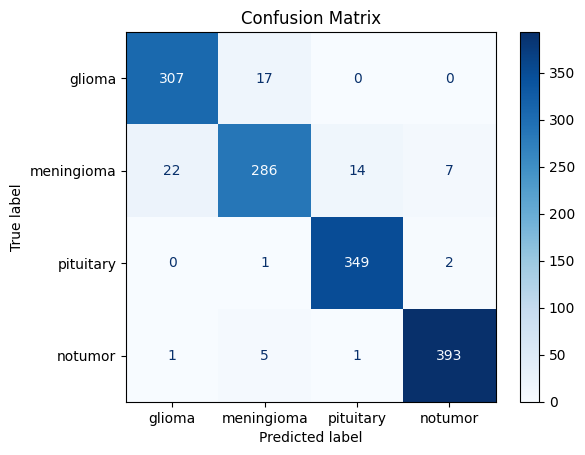

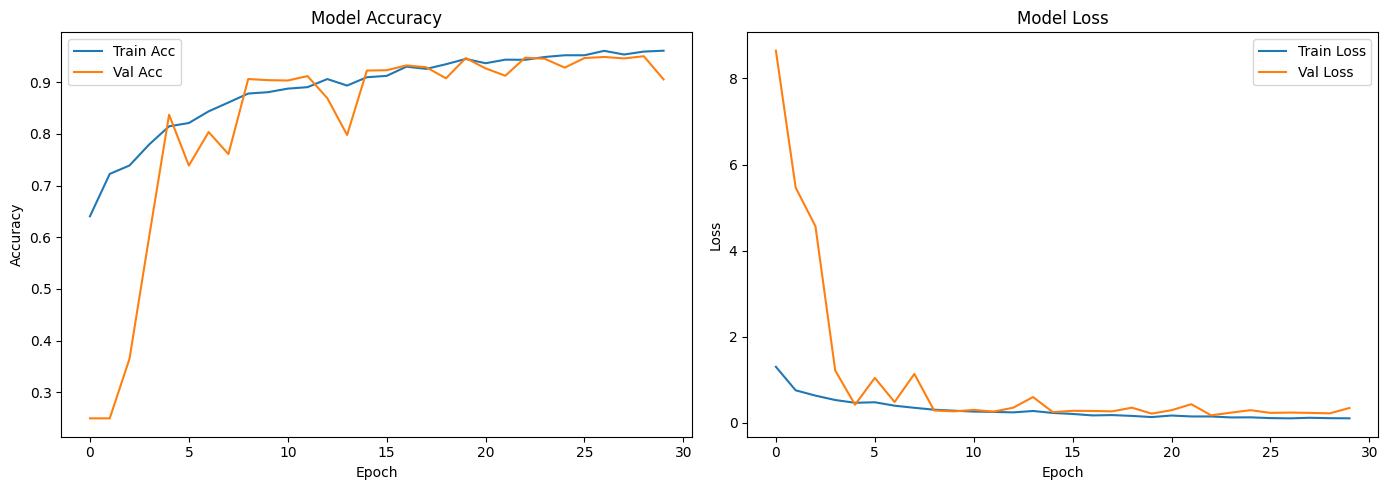

In [36]:
# ✅ Required Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# ✅ Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# ✅ Classification Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall: {rec:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

# ✅ Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=['glioma', 'meningioma', 'pituitary', 'notumor']))

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['glioma', 'meningioma', 'pituitary', 'notumor'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# ✅ Accuracy & Loss Curves
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('/kaggle/working/training_curves.png')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


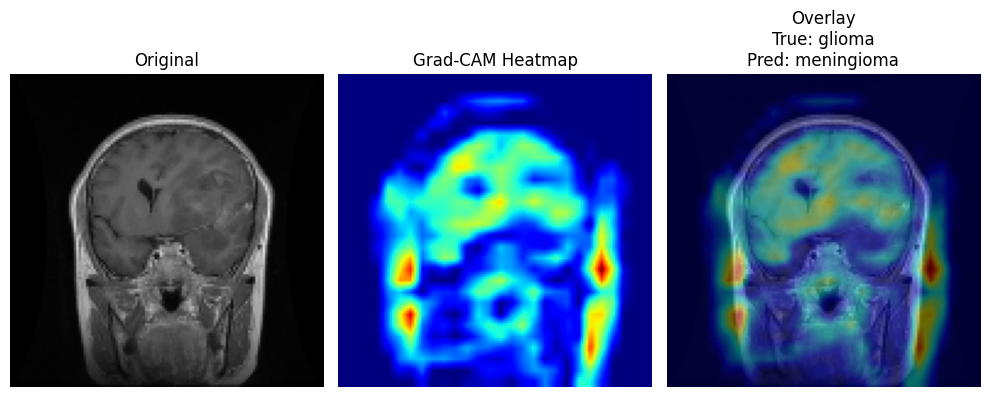

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ✅ Load trained functional model
model = tf.keras.models.load_model('/kaggle/working/final_functional_model.h5')

# ✅ Choose an image from test set
index = 5  # change to any index
sample_image = X_test[index]
sample_image_input = np.expand_dims(sample_image, axis=0)

# ✅ Predict
pred_probs = model.predict(sample_image_input)
pred_class = np.argmax(pred_probs[0])

# ✅ Class names
class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']
true_label = class_names[np.argmax(y_test[index])]
pred_label = class_names[pred_class]

# ✅ Grad-CAM function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# ✅ Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(sample_image_input, model, 'target_conv_layer')

# ✅ Overlay heatmap on image
img = sample_image
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(np.uint8(img * 255), 0.6, heatmap_colored, 0.4, 0)

# ✅ Plot and Save
plt.figure(figsize=(10,4))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap_resized, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f"Overlay\nTrue: {true_label}\nPred: {pred_label}")
plt.imshow(superimposed_img[..., ::-1])  # BGR to RGB
plt.axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/gradcam_explanation.png')
plt.show()


In [8]:
pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 5.3 MB/s eta 0:00:00


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore


def gradcam_plus_plus_visualizer(model, image_path, target_size=(128, 128), conv_layer_name='target_conv_layer'):
    """
    Generate and display Grad-CAM++ heatmap and overlay using tf-keras-vis.

    Args:
        model (tf.keras.Model): Trained classification model.
        image_path (str): Path to the MRI image.
        target_size (tuple): Image resize dimensions (default (128,128)).
        conv_layer_name (str): Name of the last convolutional layer.
    """
    # Load and preprocess image
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    input_tensor = np.expand_dims(img_array, axis=0)

    # Predict and get class index
    preds = model.predict(input_tensor)
    class_idx = np.argmax(preds[0])
    class_label = ['glioma', 'meningioma', 'pituitary', 'notumor'][class_idx]  # Modify as per your classes

    # Score and model modification
    score = CategoricalScore([class_idx])
    model_modifier = ReplaceToLinear()

    # Grad-CAM++ setup
    gradcam = GradcamPlusPlus(model, model_modifier=model_modifier)
    cam = gradcam(score, input_tensor, penultimate_layer=conv_layer_name)
    heatmap = cam[0]

    # Overlay helper
    def overlay_heatmap(img_array, heatmap, alpha=0.5):
        heatmap_resized = np.uint8(255 * heatmap)
        heatmap_resized = np.stack([heatmap_resized] * 3, axis=-1)
        overlay = np.uint8(255 * img_array) + np.uint8(alpha * heatmap_resized)
        overlay = np.clip(overlay, 0, 255).astype(np.uint8)
        return overlay

    # Plot results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_array)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title('Grad-CAM++ Heatmap')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay_heatmap(img_array, heatmap))
    plt.title(f'Overlay\nPredicted: {class_label}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [11]:
!pip install tf-keras-vis --quiet

In [12]:
import tensorflow as tf
from tf_keras_vis.scorecam import ScoreCAM
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
import matplotlib.pyplot as plt
import numpy as np

In [13]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ab1bf93929c2da5f3ba18a45171b94661fa469e8724133d3f05a2974fc4d4d7a
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [14]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb

In [15]:
explainer = lime_image.LimeImageExplainer()

# Wrap your model's prediction to accept [0, 255] uint8 image input
def predict_fn(images):
    images = np.array(images).astype(np.float32) / 255.0
    return model.predict(images)


In [16]:
i = 1  # choose any test image index
img = (X_test[i] * 255).astype(np.uint8)

explanation = explainer.explain_instance(
    image=img,
    classifier_fn=predict_fn,
    top_labels=4,
    hide_color=0,
    num_samples=1000  # Number of perturbations
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━

In [32]:
from PIL import Image
import cv2

# Load and preprocess your image
your_image_path = '/content/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0006.jpg'  # update this
img = Image.open(your_image_path).convert("RGB")
img = img.resize((128, 128))  # same as model input
img_array = np.array(img).astype(np.uint8)
input_img = img_array / 255.0


In [33]:
# Use the raw uint8 image for LIME
explanation = explainer.explain_instance(
    image=img_array,
    classifier_fn=predict_fn,
    top_labels=4,
    hide_color=0,
    num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━

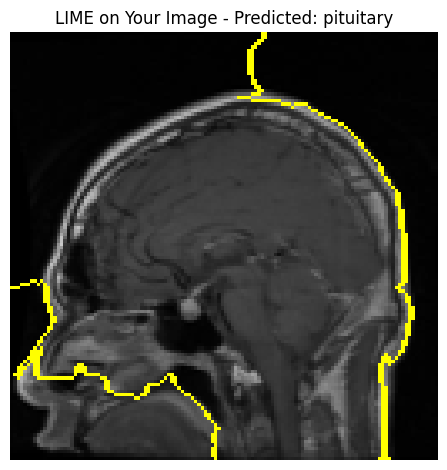

In [34]:
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME on Your Image - Predicted: {class_names[explanation.top_labels[0]]}")
plt.axis('off')
plt.tight_layout()
plt.savefig('/kaggle/working/lime_your_image.png')
plt.show()


In [35]:
# prompt: save that model

model.save('brain_tumor_model.h5')